In [3]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

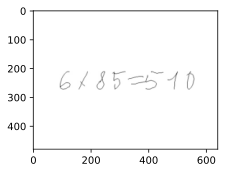

In [5]:
d2l.set_figsize()
img = d2l.plt.imread('../equation_images/2numbers_045.png')
d2l.plt.imshow(img);

In [6]:
#@save
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = tf.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = tf.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [7]:
# Here `bbox` is the abbreviation for bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [8]:
boxes = tf.constant((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

<tf.Tensor: shape=(2, 4), dtype=bool, numpy=
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True]])>

In [9]:
#@save
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

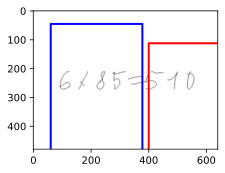

In [10]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

In [17]:
import os
import numpy as np
import random
from PIL import Image, ImageDraw
from skimage import io
import matplotlib.pyplot as plt

# Generate equations as strings
def equation_generator(numbers=2, max_num=100):
    assert numbers > 1, "You need at least two numbers to generate a valid equation"
    # Generate numbers and operators
    generated_eqn = []
    operators = ['+', '-', '*']
    for number in range(numbers):
        gen_num = np.random.randint(max_num)
        generated_eqn.append(str(gen_num))
        operator_ind = np.random.randint(len(operators))
        operator = operators[operator_ind]
        generated_eqn.append(operator)
    # Remove the last operator and turn into a string
    generated_eqn = generated_eqn[:-1]
    generated_eqn = ''.join(generated_eqn)
    ans = eval(generated_eqn)
    ans_string = '=' + str(ans)
    return generated_eqn + ans_string

# Randomly select a file from a directory
def random_sample_file(directory):
    n = 0
    random.seed()
    for root, dirs, files in os.walk(directory):
        for name in files:
            n += 1
            if random.uniform(0, n) < 1:
                rfile = os.path.join(root, name)
    return rfile

# Generate equation image with bounding boxes
def generate_eqn_image_with_bboxes(folder, eqn):
    eqn_array = []
    bounding_boxes = []
    current_x = 0  # Tracks the x-coordinate for bounding boxes

    for char in eqn:
        if char == "*": 
            char = 'times'  # Handle special character naming
        char_folder = f"{folder}/{char}"
        file = random_sample_file(char_folder)  # Randomly sample an image for the character
        img = io.imread(file)
        h, w = img.shape[:2]  # Get height and width of the current character image
        
        # Append the image to the equation array
        eqn_array.append(img)

        # Calculate the bounding box for the current character
        bounding_box = [current_x, 0, current_x + w, h]  # [x_min, y_min, x_max, y_max]
        bounding_boxes.append((char, bounding_box))
        
        # Update the x-coordinate for the next character
        current_x += w

    # Concatenate all images together into one large image
    eqn_image = np.hstack(eqn_array)

    return eqn_image, bounding_boxes

# Main script to generate dataset
output_folder = "../equation_images_boxes"
bboxes_folder = "../equation_bboxes"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
if not os.path.exists(bboxes_folder):
    os.makedirs(bboxes_folder)

EQNS = 50  # Number of equations to generate
NUMBERS = 2  # Number of numbers in each equation
MAX_NUM = 100  # Maximum value for generated numbers

for i in range(EQNS):
    eqn = equation_generator(numbers=NUMBERS, max_num=MAX_NUM)
    print(f"Equation: {eqn}")
    
    # Generate image and bounding boxes
    eqn_array, bboxes = generate_eqn_image_with_bboxes("../data", eqn)
    
    # Save the image
    filename = f"{NUMBERS}numbers_{str(i).zfill(3)}.png"
    plt.imshow(eqn_array, cmap="gray")
    plt.axis('off')
    plt.savefig(os.path.join(output_folder, filename), bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # Save the bounding boxes
    bbox_filename = f"{NUMBERS}numbers_{str(i).zfill(3)}.txt"
    with open(os.path.join(bboxes_folder, bbox_filename), "w") as f:
        for char, bbox in bboxes:
            # YOLO format: class_id x_center y_center width height (normalized)
            class_id = char  # You may map this to a numeric ID if needed
            x_min, y_min, x_max, y_max = bbox
            img_width = eqn_array.shape[1]
            img_height = eqn_array.shape[0]
            
            # Normalize coordinates for YOLO format
            x_center = (x_min + x_max) / 2 / img_width
            y_center = (y_min + y_max) / 2 / img_height
            bbox_width = (x_max - x_min) / img_width
            bbox_height = (y_max - y_min) / img_height
            
            f.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")


Equation: 78*39=3042
Equation: 66*27=1782
Equation: 52-65=-13
Equation: 62*20=1240
Equation: 50+92=142
Equation: 83-47=36
Equation: 35-65=-30
Equation: 69-19=50
Equation: 73-63=10
Equation: 63+54=117
Equation: 41+45=86
Equation: 64-57=7
Equation: 40+56=96
Equation: 69-59=10
Equation: 80+42=122
Equation: 91-49=42
Equation: 23*22=506
Equation: 42+23=65
Equation: 18-72=-54
Equation: 98+47=145
Equation: 80*85=6800
Equation: 80+3=83
Equation: 56-14=42
Equation: 90+75=165
Equation: 76+95=171
Equation: 16*99=1584
Equation: 51+86=137
Equation: 50+77=127
Equation: 66*96=6336
Equation: 32-21=11
Equation: 61*34=2074
Equation: 40-42=-2
Equation: 29-6=23
Equation: 84+73=157
Equation: 27+29=56
Equation: 96-17=79
Equation: 67+2=69
Equation: 16-74=-58
Equation: 62+61=123
Equation: 54+16=70
Equation: 69+39=108
Equation: 65+8=73
Equation: 76+81=157
Equation: 70+88=158
Equation: 49*64=3136
Equation: 54*25=1350
Equation: 77-46=31
Equation: 2-56=-54
Equation: 87+90=177
Equation: 63-24=39


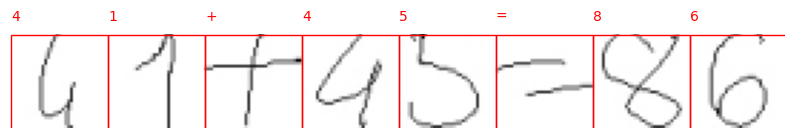

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io

def visualize_saved_eqn(image_path, bbox_path, figsize=(10, 10)):
    # Load the image
    eqn_image = io.imread(image_path)

    # Read the bounding boxes
    bboxes = []
    with open(bbox_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = parts[0]
            x_center, y_center, width, height = map(float, parts[1:])
            
            # Convert YOLO format back to pixel coordinates
            img_width = eqn_image.shape[1]
            img_height = eqn_image.shape[0]
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2
            
            bboxes.append((class_id, [x_min, y_min, x_max, y_max]))

    # Plot the image with adjusted figure size
    fig, ax = plt.subplots(1, figsize=figsize)  # Set figure size
    ax.imshow(eqn_image, cmap="gray")
    
    # Draw bounding boxes
    for class_id, bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min, 
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add the class label
        ax.text(x_min, y_min - 5, class_id, color='red', fontsize=10, 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    plt.axis('off')
    plt.show()

# Example usage
image_name = "../equation_images_boxes/2numbers_010.png"  # Correct relative path to the image
bbox_name = "../equation_bboxes/2numbers_010.txt"        # Correct relative path to the bounding box file

# Use the provided paths directly
image_path = image_name
bbox_path = bbox_name

visualize_saved_eqn(image_path, bbox_path)



In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the custom CNN
def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes + 5, activation='sigmoid')  # Output: class probabilities + bbox coords
    ])
    return model


2024-11-21 12:56:26.330699: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 12:56:26.335702: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 12:56:26.347207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 12:56:26.367818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 12:56:26.374058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 12:56:26.391684: I tensorflow/core/platform/cpu_feature_gu

In [4]:
import numpy as np

def preprocess_image(image, labels, grid_size=4):
    h, w = image.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size
    data = []
    targets = []

    for i in range(grid_size):
        for j in range(grid_size):
            # Get the region for this grid cell
            cell = image[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]
            data.append(cell)

            # Determine if this cell contains an object
            object_present = 0
            class_label = [0] * num_classes
            bbox = [0, 0, 0, 0]

            for label in labels:
                x_center, y_center, width, height = label[1:]
                grid_x = int(x_center * grid_size)
                grid_y = int(y_center * grid_size)

                if grid_x == j and grid_y == i:
                    object_present = 1
                    class_label[label[0]] = 1
                    bbox = [x_center * grid_size - j, y_center * grid_size - i, width * grid_size, height * grid_size]

            targets.append([object_present] + class_label + bbox)

    return np.array(data), np.array(targets)


In [6]:
import os
import numpy as np
from skimage import io

def load_data(image_folder, bbox_folder):
    images = []
    targets = []

    # Get sorted list of valid image and label files
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
    bbox_files = sorted([f for f in os.listdir(bbox_folder) if f.endswith('.txt')])
    
    # Ensure image and label files match
    assert len(image_files) == len(bbox_files), "Mismatch between images and labels!"
    
    for img_file, bbox_file in zip(image_files, bbox_files):
        # Load the image
        img_path = os.path.join(image_folder, img_file)
        img = io.imread(img_path, as_gray=True)  # Load as grayscale
        images.append(img)
        
        # Load the corresponding bounding box file
        bbox_path = os.path.join(bbox_folder, bbox_file)
        with open(bbox_path, 'r') as f:
            boxes = []
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                boxes.append([class_id, x_center, y_center, width, height])
            targets.append(boxes)
    
    return np.array(images), targets



In [7]:
from sklearn.model_selection import train_test_split

# Load the data
image_folder = "../equation_images_boxes"
bbox_folder = "../equation_bboxes"

X, Y = load_data(image_folder, bbox_folder)

# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


ValueError: invalid literal for int() with base 10: 'times'

In [3]:
import os
import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split

# Step 1: Define the class label mapping
CLASS_LABELS = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, 
    '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    '+': 10, '-': 11, 'times': 12, '=': 13
}

# Step 2: Load images and bounding box data
from skimage.transform import resize

def load_data(image_folder, bbox_folder, target_size=(128, 128)):
    images = []
    targets = []

    # Get sorted list of valid image and label files
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
    bbox_files = sorted([f for f in os.listdir(bbox_folder) if f.endswith('.txt')])
    
    # Ensure image and label files match
    assert len(image_files) == len(bbox_files), "Mismatch between images and labels!"
    
    for img_file, bbox_file in zip(image_files, bbox_files):
        # Load the image
        img_path = os.path.join(image_folder, img_file)
        img = io.imread(img_path, as_gray=True)  # Load as grayscale
        img = resize(img, target_size, anti_aliasing=True)  # Resize to fixed dimensions
        images.append(img)
        
        # Load the corresponding bounding box file
        bbox_path = os.path.join(bbox_folder, bbox_file)
        with open(bbox_path, 'r') as f:
            boxes = []
            for line in f:
                parts = line.strip().split()
                class_label = parts[0]  # Read the label as a string
                x_center, y_center, width, height = map(float, parts[1:])
                
                # Map the class label to its numeric ID
                if class_label in CLASS_LABELS:
                    class_id = CLASS_LABELS[class_label]
                else:
                    raise ValueError(f"Unknown class label: {class_label}")
                
                boxes.append([class_id, x_center, y_center, width, height])
            targets.append(boxes)
    
    return np.array(images), targets


# Step 3: Preprocess the data into grid cells
def preprocess_image(image, labels, grid_size=4, num_classes=14):
    h, w = image.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size
    data = []
    targets = []

    for i in range(grid_size):
        for j in range(grid_size):
            # Get the region for this grid cell
            cell = image[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]
            data.append(cell)

            # Determine if this cell contains an object
            object_present = 0
            class_label = [0] * num_classes
            bbox = [0, 0, 0, 0]

            for label in labels:
                x_center, y_center, width, height = label[1:]
                grid_x = int(x_center * grid_size)
                grid_y = int(y_center * grid_size)

                if grid_x == j and grid_y == i:
                    object_present = 1
                    class_label[label[0]] = 1
                    bbox = [x_center * grid_size - j, y_center * grid_size - i, width * grid_size, height * grid_size]

            targets.append([object_present] + class_label + bbox)

    return np.array(data), np.array(targets)

def preprocess_data(images, targets, grid_size=4, num_classes=14):
    X = []
    Y = []
    for img, target in zip(images, targets):
        img_preprocessed, target_preprocessed = preprocess_image(img, target, grid_size=grid_size)
        X.append(img_preprocessed)
        Y.append(target_preprocessed)
    
    # Convert to NumPy arrays
    X = np.concatenate(X)  # Shape: (num_grid_cells, cell_height, cell_width)
    Y = np.concatenate(Y)  # Shape: (num_grid_cells, output_size)
    
    # Normalize images to range [0, 1]
    X = X / 255.0
    return X, Y

# Step 4: Load and split the dataset
image_folder = "../equation_images_boxes"
bbox_folder = "../equation_bboxes"

X, Y = load_data(image_folder, bbox_folder)

# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Preprocess the data for the CNN
grid_size = 4
num_classes = len(CLASS_LABELS)
X_train_processed, Y_train_processed = preprocess_data(X_train, Y_train, grid_size, num_classes)
X_val_processed, Y_val_processed = preprocess_data(X_val, Y_val, grid_size, num_classes)


In [5]:
# Step 5: Train the CNN
from tensorflow.keras import layers, models
import tensorflow as tf

def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes + 5, activation='sigmoid')  # Output: class probabilities + bbox coords
    ])
    return model

def custom_loss(y_true, y_pred):
    obj_loss = tf.keras.losses.BinaryCrossentropy()(y_true[:, 0], y_pred[:, 0])
    class_loss = tf.keras.losses.CategoricalCrossentropy()(y_true[:, 1:num_classes+1], y_pred[:, 1:num_classes+1])
    bbox_loss = tf.keras.losses.MeanSquaredError()(y_true[:, num_classes+1:], y_pred[:, num_classes+1:])
    return obj_loss + class_loss + bbox_loss

model = build_custom_cnn((32, 32, 1), num_classes)
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [18]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,395 (1.36 MB)

 Trainable params: 357,395 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
model = build_custom_cnn((128, 128, 1), num_classes)
print(model.summary())


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,307 (49.36 MB)

 Trainable params: 12,940,307 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
history = model.fit(
    X_train_processed, Y_train_processed,
    validation_data=(X_val_processed, Y_val_processed),
    epochs=20, batch_size=32)

SyntaxError: incomplete input (1750628480.py, line 4)

In [13]:
import numpy as np

def decode_predictions(predictions, grid_size, image_shape, threshold=0.5):
    """
    Decodes CNN predictions into bounding boxes and class labels.

    Args:
    - predictions: CNN output for the image (grid_size x grid_size x (num_classes + 5)).
    - grid_size: The size of the grid (e.g., 4 for a 4x4 grid).
    - image_shape: Original shape of the input image (height, width).
    - threshold: Confidence threshold for object detection.

    Returns:
    - decoded_boxes: List of bounding boxes as [x_min, y_min, x_max, y_max].
    - decoded_classes: List of class IDs for each detected object.
    """
    decoded_boxes = []
    decoded_classes = []
    img_h, img_w = image_shape
    cell_h, cell_w = img_h / grid_size, img_w / grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            cell_pred = predictions[i, j]
            
            # Extract the object confidence
            object_present = cell_pred[0]
            if object_present > threshold:
                # Extract class probabilities and determine the class ID
                class_probs = cell_pred[1:-4]
                class_id = np.argmax(class_probs)
                
                # Extract bounding box parameters
                x_center, y_center, box_w, box_h = cell_pred[-4:]
                x_center = (x_center + j) * cell_w  # Scale relative to image
                y_center = (y_center + i) * cell_h
                box_w *= img_w
                box_h *= img_h
                
                # Calculate box corners
                x_min = int(x_center - box_w / 2)
                y_min = int(y_center - box_h / 2)
                x_max = int(x_center + box_w / 2)
                y_max = int(y_center + box_h / 2)

                # Append to results
                decoded_boxes.append([x_min, y_min, x_max, y_max])
                decoded_classes.append(class_id)
    
    return decoded_boxes, decoded_classes


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, boxes, classes, class_labels):
    """
    Visualizes the predictions on the image with bounding boxes and class labels.

    Args:
    - image: Original input image (height x width).
    - boxes: List of bounding boxes as [x_min, y_min, x_max, y_max].
    - classes: List of class IDs for each detected object.
    - class_labels: Mapping of class IDs to label names.
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    for box, class_id in zip(boxes, classes):
        x_min, y_min, x_max, y_max = box
        label = class_labels[class_id]
        
        # Draw the bounding box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Add the class label
        ax.text(x_min, y_min - 5, label, color='red', fontsize=12, 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    plt.axis('off')
    plt.show()


In [16]:
# Ensure the test image is preprocessed correctly
test_image = X_val[0]  # Replace with any test image
test_image_input = np.expand_dims(test_image, axis=(0, -1))  # Shape: (1, height, width, 1)

# Get predictions from the CNN
grid_size = 4  # Ensure this matches the grid size used during training
predictions = model.predict(test_image_input)[0]  # Shape: (grid_size, grid_size, num_classes + 5)

# Decode predictions
decoded_boxes, decoded_classes = decode_predictions(predictions, grid_size, test_image.shape)

# Visualize predictions
visualize_predictions(test_image, decoded_boxes, decoded_classes, {v: k for k, v in CLASS_LABELS.items()})


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 2048, but received input with shape (1, 100352)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 128, 128, 1), dtype=float32)
  • training=False
  • mask=None

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 4, 4, 19)       │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,123 (371.57 KB)

 Trainable params: 95,123 (371.57 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


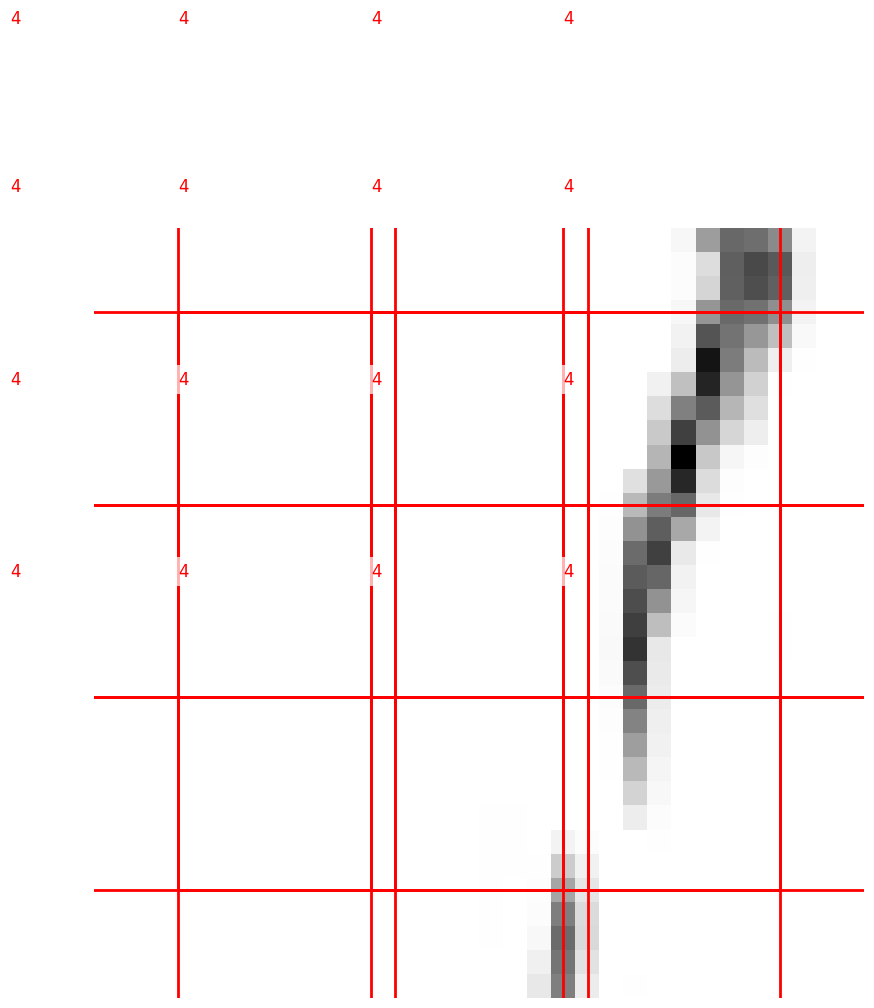

In [20]:
# Step 1: Define the CNN Model
from tensorflow.keras import layers, models
import tensorflow as tf

CLASS_LABELS = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, 
    '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    '+': 10, '-': 11, 'times': 12, '=': 13
}

def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Conv2D(num_classes + 5, (1, 1), activation='sigmoid')  # Predict per grid cell
    ])
    return model


# Custom loss function for training
def custom_loss(y_true, y_pred):
    obj_loss = tf.keras.losses.BinaryCrossentropy()(y_true[:, 0], y_pred[:, 0])
    class_loss = tf.keras.losses.CategoricalCrossentropy()(y_true[:, 1:num_classes+1], y_pred[:, 1:num_classes+1])
    bbox_loss = tf.keras.losses.MeanSquaredError()(y_true[:, num_classes+1:], y_pred[:, num_classes+1:])
    return obj_loss + class_loss + bbox_loss

# Build and compile the model
input_shape = (32, 32, 1)  # Ensure this matches your data
num_classes = len(CLASS_LABELS)  # Ensure CLASS_LABELS is defined elsewhere
model = build_custom_cnn(input_shape, num_classes)
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Print model summary for debugging
print(model.summary())

# Step 2: Define Helper Functions for Decoding Predictions
import numpy as np

def decode_predictions(predictions, grid_size, image_shape, threshold=0.5):
    """
    Decodes CNN predictions into bounding boxes and class labels.

    Args:
    - predictions: CNN output for the image (grid_size x grid_size x (num_classes + 5)).
    - grid_size: The size of the grid (e.g., 4 for a 4x4 grid).
    - image_shape: Original shape of the input image (height, width).
    - threshold: Confidence threshold for object detection.

    Returns:
    - decoded_boxes: List of bounding boxes as [x_min, y_min, x_max, y_max].
    - decoded_classes: List of class IDs for each detected object.
    """
    decoded_boxes = []
    decoded_classes = []
    img_h, img_w = image_shape
    cell_h, cell_w = img_h / grid_size, img_w / grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            cell_pred = predictions[i, j]
            
            # Extract the object confidence
            object_present = cell_pred[0]
            if object_present > threshold:
                # Extract class probabilities and determine the class ID
                class_probs = cell_pred[1:num_classes+1]
                class_id = np.argmax(class_probs)
                
                # Extract bounding box parameters
                x_center, y_center, box_w, box_h = cell_pred[-4:]
                x_center = (x_center + j) * cell_w  # Scale relative to image
                y_center = (y_center + i) * cell_h
                box_w *= img_w
                box_h *= img_h
                
                # Calculate box corners
                x_min = int(x_center - box_w / 2)
                y_min = int(y_center - box_h / 2)
                x_max = int(x_center + box_w / 2)
                y_max = int(y_center + box_h / 2)

                # Append to results
                decoded_boxes.append([x_min, y_min, x_max, y_max])
                decoded_classes.append(class_id)
    
    return decoded_boxes, decoded_classes

# Step 3: Visualization Function
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, boxes, classes, class_labels):
    """
    Visualizes the predictions on the image with bounding boxes and class labels.

    Args:
    - image: Original input image (height x width).
    - boxes: List of bounding boxes as [x_min, y_min, x_max, y_max].
    - classes: List of class IDs for each detected object.
    - class_labels: Mapping of class IDs to label names.
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    for box, class_id in zip(boxes, classes):
        x_min, y_min, x_max, y_max = box
        label = class_labels[class_id]
        
        # Draw the bounding box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Add the class label
        ax.text(x_min, y_min - 5, label, color='red', fontsize=12, 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    plt.axis('off')
    plt.show()

# Step 4: Preprocess Test Image
test_image = X_val_processed[1]  # Replace with your test image
test_image_input = np.expand_dims(test_image, axis=(0, -1))  # Shape: (1, 32, 32, 1)

# Step 5: Get Predictions and Visualize
grid_size = 4  # Matches the grid size used in training
predictions = model.predict(test_image_input)[0].reshape(grid_size, grid_size, num_classes + 5)

# Decode predictions
decoded_boxes, decoded_classes = decode_predictions(predictions, grid_size, test_image.shape)

# Visualize predictions
visualize_predictions(test_image, decoded_boxes, decoded_classes, {v: k for k, v in CLASS_LABELS.items()})


In [13]:
print(model.input_shape)

(None, 32, 32, 1)


In [14]:
print("Shape of test image before preprocessing:", test_image.shape)


Shape of test image before preprocessing: (32, 32)


In [18]:
layers.Dense(num_classes + 5, activation='sigmoid')


<Dense name=dense_12, built=False>

In [21]:
image = "../equation_images_boxes/2numbers_010.png"

In [29]:
import numpy as np
from skimage.transform import resize
from skimage.io import imread

# Path to the image
image_path = "../equation_images_boxes/2numbers_009.png"

# Step 1: Load the image
image = imread(image_path, as_gray=True)  # Load as grayscale

# Step 2: Resize the image to match CNN input shape
image_resized = resize(image, (32, 32), anti_aliasing=True)

# Step 3: Add the channel dimension
image_with_channel = np.expand_dims(image_resized, axis=-1)  # Shape: (32, 32, 1)

# Step 4: Add the batch dimension
image_for_cnn = np.expand_dims(image_with_channel, axis=0)  # Shape: (1, 32, 32, 1)

# Check the size
print("Original image shape:", image.shape)
print("Resized image shape (for CNN):", image_for_cnn.shape)


Original image shape: (30, 271)
Resized image shape (for CNN): (1, 32, 32, 1)


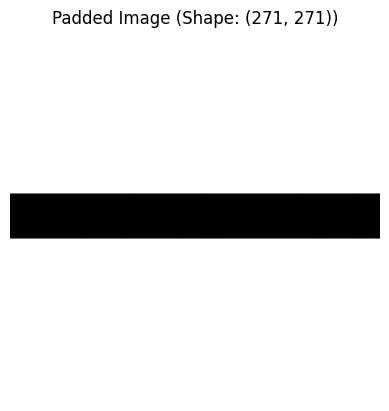

In [32]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

def pad_to_square(image, background_value=255):
    """
    Pads an image to make it a square by adding background padding.

    Args:
    - image: Input image (numpy array).
    - background_value: Background color (default is 255 for white).

    Returns:
    - padded_image: Square padded image.
    """
    h, w = image.shape[:2]
    if h == w:
        return image  # Already a square

    # Determine padding
    if h > w:  # Add padding to the width
        pad_width = (h - w) // 2
        padding = ((0, 0), (pad_width, pad_width))
    else:  # Add padding to the height
        pad_height = (w - h) // 2
        padding = ((pad_height, pad_height), (0, 0))

    # Pad the image
    padded_image = np.pad(image, padding, mode='constant', constant_values=background_value)
    return padded_image

# Example usage
image_path = "../equation_images_boxes/2numbers_010.png"
image = imread(image_path, as_gray=True)

# Pad the image
padded_image = pad_to_square(image)

# Visualize the result
plt.imshow(padded_image, cmap='gray')
plt.title(f"Padded Image (Shape: {padded_image.shape})")
plt.axis('off')
plt.show()


In [36]:
from skimage import io
import numpy as np
import os
import random
from skimage.transform import resize
import matplotlib.pyplot as plt

# Generate equations as strings
def equation_generator(numbers=2, max_num=100):
    assert numbers > 1, "You need at least two numbers to generate a valid equation"
    # Generate numbers and operators
    generated_eqn = []
    operators = ['+', '-', '*']
    for number in range(numbers):
        gen_num = np.random.randint(max_num)
        generated_eqn.append(str(gen_num))
        operator_ind = np.random.randint(len(operators))
        operator = operators[operator_ind]
        generated_eqn.append(operator)
    # Remove the last operator and turn into a string
    generated_eqn = generated_eqn[:-1]
    generated_eqn = ''.join(generated_eqn)
    ans = eval(generated_eqn)
    ans_string = '=' + str(ans)
    return generated_eqn + ans_string

# Randomly select a file from a directory
def random_sample_file(directory):
    n = 0
    random.seed()
    for root, dirs, files in os.walk(directory):
        for name in files:
            n += 1
            if random.uniform(0, n) < 1:
                rfile = os.path.join(root, name)
    return rfile

# Generate equation image with bounding boxes and make it square
# Generate equation image with bounding boxes and make it square
def generate_eqn_image_with_bboxes(folder, eqn, target_size=128):
    eqn_array = []
    bounding_boxes = []
    current_x = 0  # Tracks the x-coordinate for bounding boxes

    # Step 1: Concatenate character images to create a single wide image
    for char in eqn:
        if char == "*": 
            char = 'times'  # Handle special character naming
        char_folder = f"{folder}/{char}"
        file = random_sample_file(char_folder)  # Randomly sample an image for the character
        img = io.imread(file)
        h, w = img.shape[:2]  # Get height and width of the current character image
        
        # Append the image to the equation array
        eqn_array.append(img)

        # Calculate the bounding box for the current character
        bounding_box = [current_x, 0, current_x + w, h]  # [x_min, y_min, x_max, y_max]
        bounding_boxes.append((char, bounding_box))
        
        # Update the x-coordinate for the next character
        current_x += w

    # Concatenate all images horizontally
    eqn_image = np.hstack(eqn_array)

    # Step 2: Pad the image to make it square
    h, w = eqn_image.shape[:2]
    if w > h:  # Add padding to the height
        pad_top = (w - h) // 2
        pad_bottom = w - h - pad_top
        eqn_image = np.pad(eqn_image, ((pad_top, pad_bottom), (0, 0)), mode='constant', constant_values=255)
    elif h > w:  # Add padding to the width
        pad_left = (h - w) // 2
        pad_right = h - w - pad_left
        eqn_image = np.pad(eqn_image, ((0, 0), (pad_left, pad_right)), mode='constant', constant_values=255)

    # Step 3: Adjust bounding boxes for padding
    h_padded, w_padded = eqn_image.shape[:2]
    new_bounding_boxes = []
    for char, bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox

        # Adjust y-coordinates if vertical padding was added
        if w > h:  # Vertical padding
            y_min += pad_top
            y_max += pad_top
        # Adjust x-coordinates if horizontal padding was added
        elif h > w:  # Horizontal padding
            x_min += pad_left
            x_max += pad_left

        new_bounding_boxes.append((char, [x_min, y_min, x_max, y_max]))

    # Step 4: Resize to target size
    eqn_image_resized = resize(eqn_image, (target_size, target_size), anti_aliasing=True)

    # Step 5: Adjust bounding boxes for resizing
    scale_x = target_size / w_padded
    scale_y = target_size / h_padded
    resized_bounding_boxes = []
    for char, bbox in new_bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        x_min = int(x_min * scale_x)
        x_max = int(x_max * scale_x)
        y_min = int(y_min * scale_y)
        y_max = int(y_max * scale_y)
        resized_bounding_boxes.append((char, [x_min, y_min, x_max, y_max]))

    return eqn_image_resized, resized_bounding_boxes


# Main script to generate dataset
output_folder = "../equation_images_squares"
bboxes_folder = "../equation_bboxes_squares"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
if not os.path.exists(bboxes_folder):
    os.makedirs(bboxes_folder)

EQNS = 150  # Number of equations to generate
NUMBERS = 2  # Number of numbers in each equation
MAX_NUM = 100  # Maximum value for generated numbers

for i in range(EQNS):
    eqn = equation_generator(numbers=NUMBERS, max_num=MAX_NUM)
    print(f"Equation: {eqn}")
    
    # Generate image and bounding boxes
    eqn_array, bboxes = generate_eqn_image_with_bboxes("../data", eqn, target_size=128)
    
    # Save the image
    filename = f"{NUMBERS}numbers_{str(i).zfill(3)}.png"
    plt.imshow(eqn_array, cmap="gray")
    plt.axis('off')
    plt.savefig(os.path.join(output_folder, filename), bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # Save the bounding boxes
    bbox_filename = f"{NUMBERS}numbers_{str(i).zfill(3)}.txt"
    with open(os.path.join(bboxes_folder, bbox_filename), "w") as f:
        for char, bbox in bboxes:
            class_id = CLASS_LABELS[char]  # Use CLASS_LABELS to map to numeric IDs
            x_min, y_min, x_max, y_max = bbox
            img_width = eqn_array.shape[1]
            img_height = eqn_array.shape[0]
            
            # Normalize coordinates for YOLO format
            x_center = (x_min + x_max) / 2 / img_width
            y_center = (y_min + y_max) / 2 / img_height
            bbox_width = (x_max - x_min) / img_width
            bbox_height = (y_max - y_min) / img_height
            
            f.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")


Equation: 59-7=52
Equation: 19*40=760
Equation: 50-48=2
Equation: 17*63=1071
Equation: 29*57=1653
Equation: 24-13=11
Equation: 17*77=1309
Equation: 6*62=372
Equation: 99-92=7
Equation: 30+5=35
Equation: 40*3=120
Equation: 91+75=166
Equation: 33*62=2046
Equation: 11+45=56
Equation: 3+76=79
Equation: 60-42=18
Equation: 53-40=13
Equation: 47-10=37
Equation: 89+49=138
Equation: 12*67=804
Equation: 56+48=104
Equation: 4-97=-93
Equation: 36*93=3348
Equation: 6*85=510
Equation: 76-72=4
Equation: 51-74=-23
Equation: 37*80=2960
Equation: 41+88=129
Equation: 20+11=31
Equation: 51+73=124
Equation: 78*10=780
Equation: 72*26=1872
Equation: 75+14=89
Equation: 97-70=27
Equation: 25-4=21
Equation: 31-42=-11
Equation: 65+28=93
Equation: 95-82=13
Equation: 43+98=141
Equation: 17-73=-56
Equation: 23-60=-37
Equation: 14+7=21
Equation: 25*74=1850
Equation: 10*42=420
Equation: 92*67=6164
Equation: 87*78=6786
Equation: 99*20=1980
Equation: 80*35=2800
Equation: 28+48=76
Equation: 78+51=129
Equation: 36+63=99


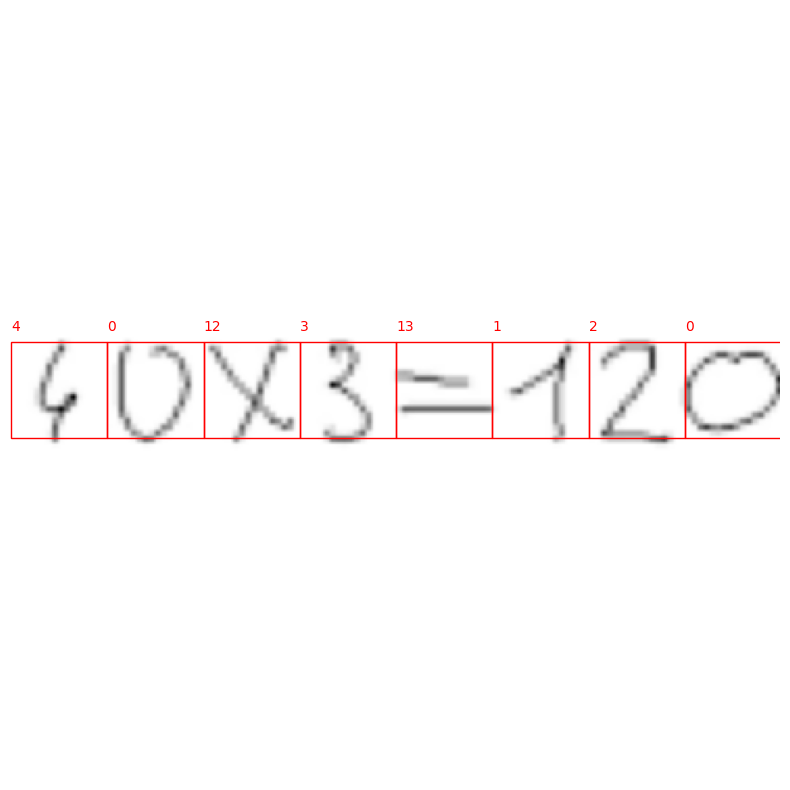

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io

def visualize_saved_eqn(image_path, bbox_path, figsize=(10, 10)):
    # Load the image
    eqn_image = io.imread(image_path)

    # Read the bounding boxes
    bboxes = []
    with open(bbox_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = parts[0]
            x_center, y_center, width, height = map(float, parts[1:])
            
            # Convert YOLO format back to pixel coordinates
            img_width = eqn_image.shape[1]
            img_height = eqn_image.shape[0]
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2
            
            bboxes.append((class_id, [x_min, y_min, x_max, y_max]))

    # Plot the image with adjusted figure size
    fig, ax = plt.subplots(1, figsize=figsize)  # Set figure size
    ax.imshow(eqn_image, cmap="gray")
    
    # Draw bounding boxes
    for class_id, bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min, 
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add the class label
        ax.text(x_min, y_min - 5, class_id, color='red', fontsize=10, 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    plt.axis('off')
    plt.show()

# Example usage
image_name = "../equation_images_squares/2numbers_010.png"  # Correct relative path to the image
bbox_name = "../equation_bboxes_squares/2numbers_010.txt"        # Correct relative path to the bounding box file

# Use the provided paths directly
image_path = image_name
bbox_path = bbox_name

visualize_saved_eqn(image_path, bbox_path)

